# Image Comparison Analysis

This notebook analyzes the results from image fidelity comparisons using various metrics: MSE, PSNR, SSIM, and LPIPS.

Key components of output quality:
- Size, aspect ratio, resolution conforms to expectations 
- Fidelity: similarity to original image
- Artifact detection, object detection, natural body geometry 

Fidelity measurements:
- MSE / PSNR: calculation of pixel by pixel differences 
    disadvantage: subject text can (and should) move
    advantage: silent to noise / blurring / changes in resolution
    best in situations where we want to detect the consistency of a portion of the source image (example: seperate image into background, subject, text, check fidelity of the subject)
- SSIM: better correlated with the perception of the human visual system 
- LPIPS: pretrained CNN, attempts to get closer to nuances of human perception 

Problems:

Image size, cropping, scaling
    - Images must be identical size
    - For expanded images we need to crop, how to select area to crop
    - Missing exapnded areas in comparison
    - if output image is smaller than input image we need to scale down input image (always scale down not up)



Questions:
    - Output image larger than expected (example: Pass in 1,000 x 1,000 image, if we want a 16x9 aspect ratio we might expect a 1,000 x 1,777 )
        - the more pixels we generate, the more potential for mistakes / hallucinations
    - Sometimes image is gen expanded to acheive aspect ratio, sometimes it is cropped

    


 # Interpretation
 
- MSE: Lower values indicate better similarity (0 = identical)
- PSNR: Higher values indicate better quality (>30 dB is generally good)
- SSIM: Values range from -1 to 1, where 1 = identical
- LPIPS: Lower values indicate better perceptual similarity (0 = identical)
        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
df = pd.read_csv("metrics_output/image_comparison_results_REAL.csv")
print(f"Loaded {len(df)} comparison results")
df


Loaded 5 comparison results


,input_image,output_image,mse,psnr,ssim,lpips,timestamp
0,examples_real/1/input.jpg,examples_real/1/output.png,11433.239669,7.549111,0.187970,0.585570,2025-09-28 23:36:15
1,examples_real/2/input.jpeg,examples_real/2/output.png,19178.151009,5.302736,0.072950,0.637242,2025-09-28 23:36:16
2,examples_real/3/input.jpg,examples_real/3/output.png,9658.621920,8.281652,0.185362,0.560500,2025-09-28 23:36:16
3,examples_real/4/input.jpg,examples_real/4/output.png,7140.151627,9.593729,0.288687,0.640288,2025-09-28 23:36:16
4,examples_real/5/input.jpg,examples_real/5/output.pn.png,14137.442642,6.627095,0.065023,0.729180,2025-09-28 23:36:17


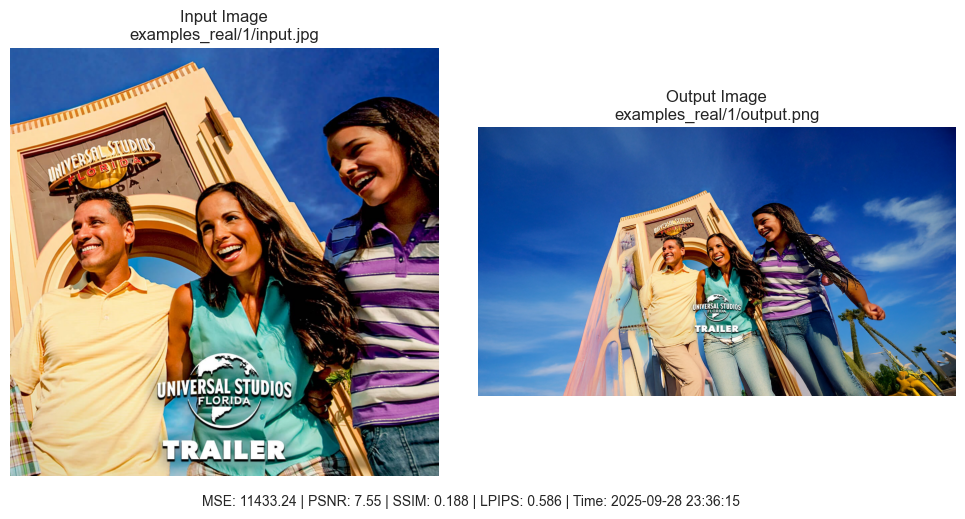

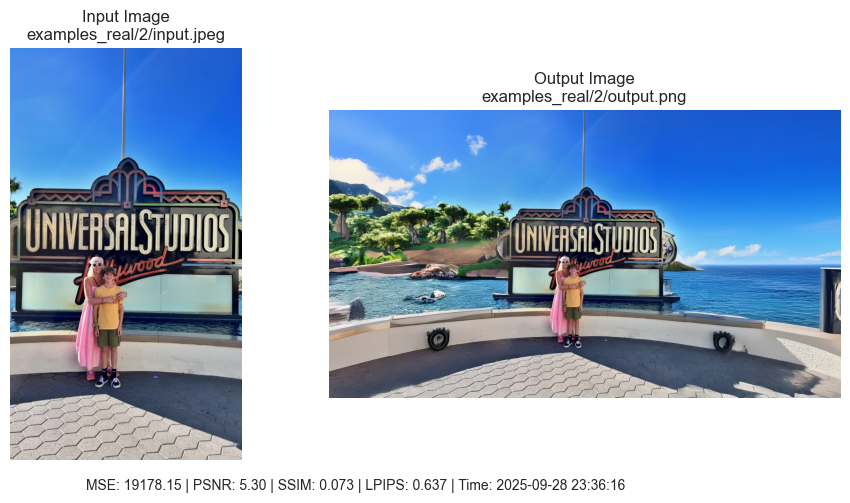

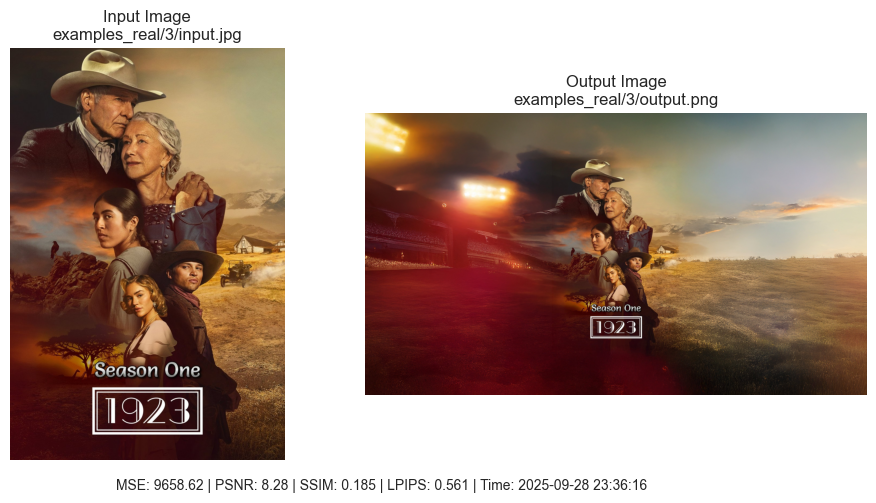

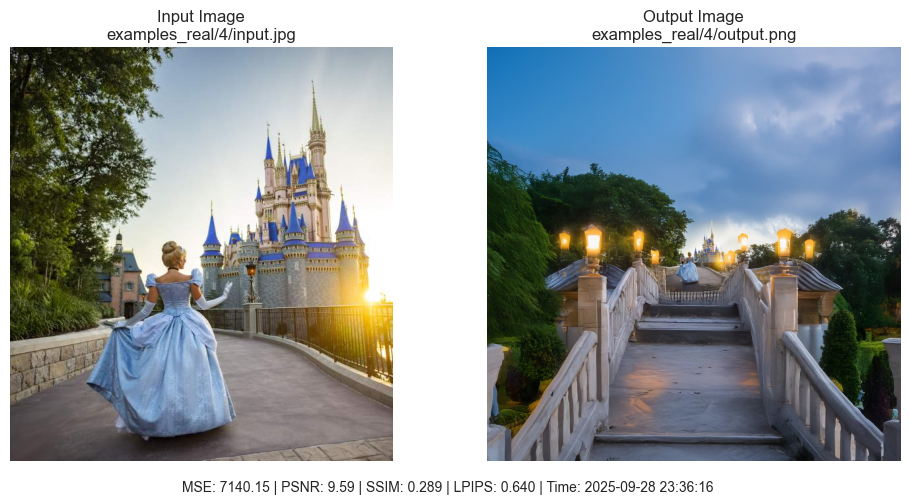

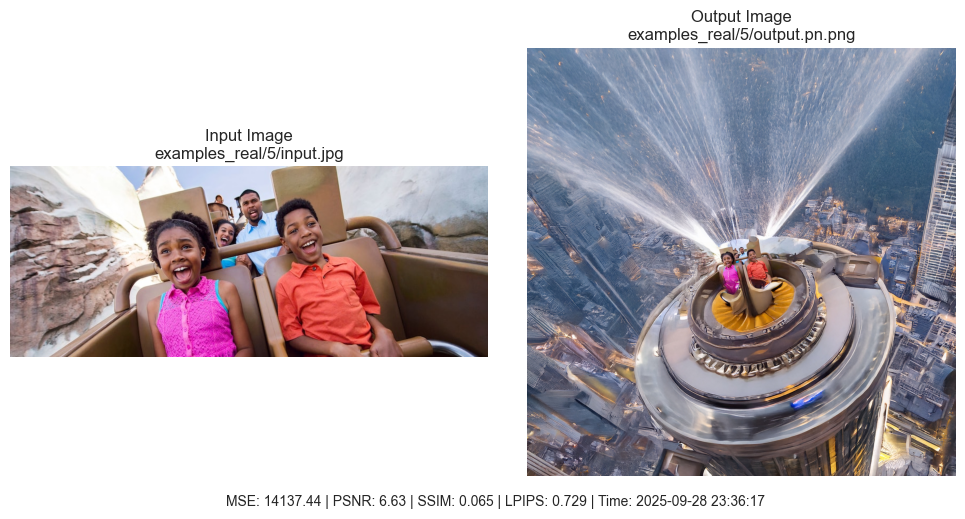

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

for idx, row in df.iterrows():
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Load images
    img1 = Image.open(row['input_image'])
    img2 = Image.open(row['output_image'])
    # Show input image
    axes[0].imshow(img1)
    axes[0].set_title(f"Input Image\n{row['input_image']}")
    axes[0].axis('off')
    # Show output image
    axes[1].imshow(img2)
    axes[1].set_title(f"Output Image\n{row['output_image']}")
    axes[1].axis('off')
    # Display metrics as text below the images
    plt.figtext(0.5, 0.01,
        f"MSE: {row['mse']:.2f} | PSNR: {row['psnr']:.2f} | SSIM: {row['ssim']:.3f} | LPIPS: {row['lpips']:.3f} | Time: {row['timestamp']}",
        ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

## Metric Distributions

Let's visualize the distribution of each metric across all comparisons.


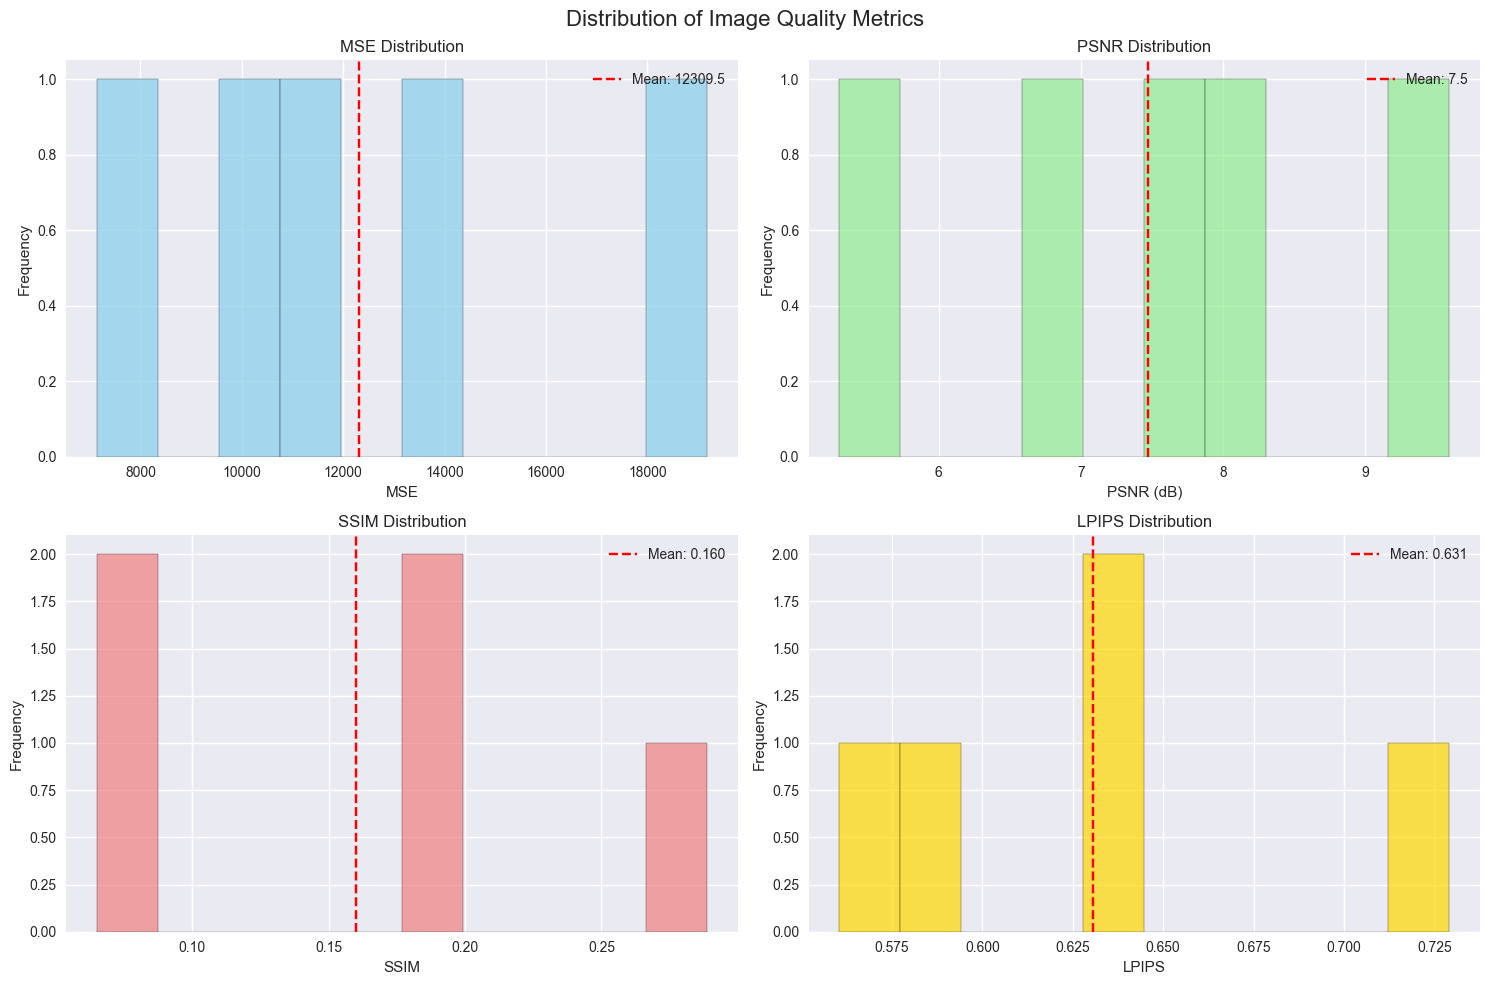

In [3]:
# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Image Quality Metrics', fontsize=16)

# MSE distribution
axes[0, 0].hist(df['mse'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('MSE Distribution')
axes[0, 0].set_xlabel('MSE')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['mse'].mean(), color='red', linestyle='--', label=f'Mean: {df["mse"].mean():.1f}')
axes[0, 0].legend()

# PSNR distribution
axes[0, 1].hist(df['psnr'], bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('PSNR Distribution')
axes[0, 1].set_xlabel('PSNR (dB)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['psnr'].mean(), color='red', linestyle='--', label=f'Mean: {df["psnr"].mean():.1f}')
axes[0, 1].legend()

# SSIM distribution
axes[1, 0].hist(df['ssim'], bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('SSIM Distribution')
axes[1, 0].set_xlabel('SSIM')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['ssim'].mean(), color='red', linestyle='--', label=f'Mean: {df["ssim"].mean():.3f}')
axes[1, 0].legend()

# LPIPS distribution
axes[1, 1].hist(df['lpips'], bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('LPIPS Distribution')
axes[1, 1].set_xlabel('LPIPS')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df['lpips'].mean(), color='red', linestyle='--', label=f'Mean: {df["lpips"].mean():.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## Correlation Analysis

Let's examine how the different metrics correlate with each other.


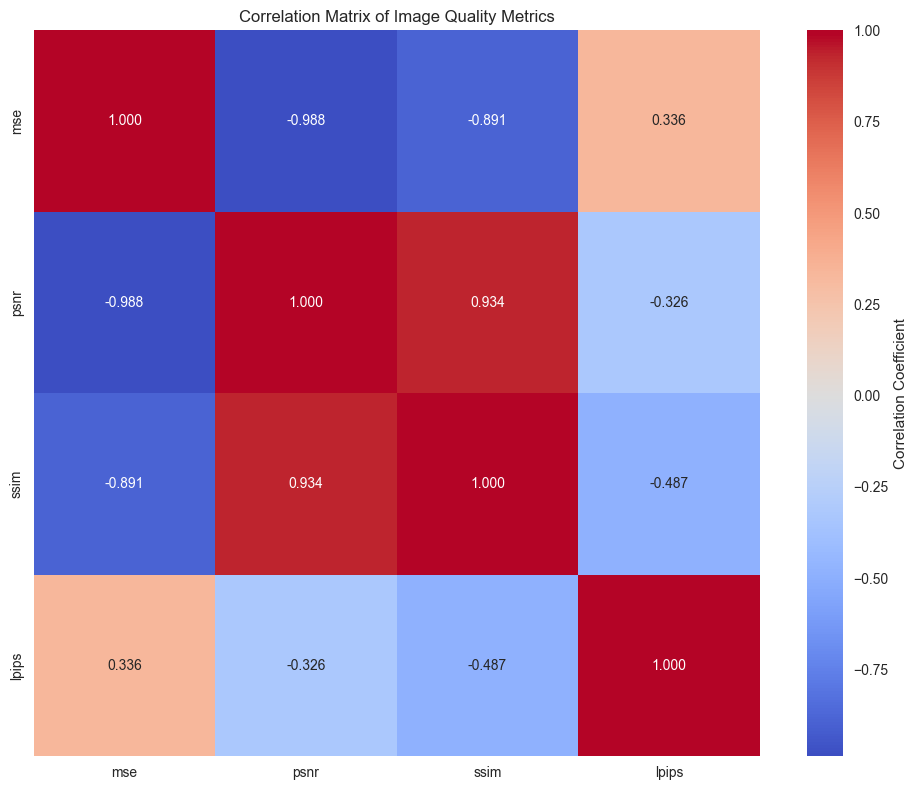


Correlation Insights:
------------------------------
MSE vs PSNR: -0.988 (strong negative correlation - expected)
MSE vs SSIM: -0.891 (negative correlation - expected)
PSNR vs SSIM: 0.934 (positive correlation - expected)
LPIPS vs MSE: 0.336 (correlation with pixel-based metric)
LPIPS vs SSIM: -0.487 (correlation with structural metric)


In [4]:
# Correlation matrix
metrics = ['mse', 'psnr', 'ssim', 'lpips']
correlation_matrix = df[metrics].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Image Quality Metrics')
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print("-" * 30)
print(f"MSE vs PSNR: {correlation_matrix.loc['mse', 'psnr']:.3f} (strong negative correlation - expected)")
print(f"MSE vs SSIM: {correlation_matrix.loc['mse', 'ssim']:.3f} (negative correlation - expected)")
print(f"PSNR vs SSIM: {correlation_matrix.loc['psnr', 'ssim']:.3f} (positive correlation - expected)")
print(f"LPIPS vs MSE: {correlation_matrix.loc['lpips', 'mse']:.3f} (correlation with pixel-based metric)")
print(f"LPIPS vs SSIM: {correlation_matrix.loc['lpips', 'ssim']:.3f} (correlation with structural metric)")


## Scatter Plot Analysis

Let's create scatter plots to visualize relationships between metrics.


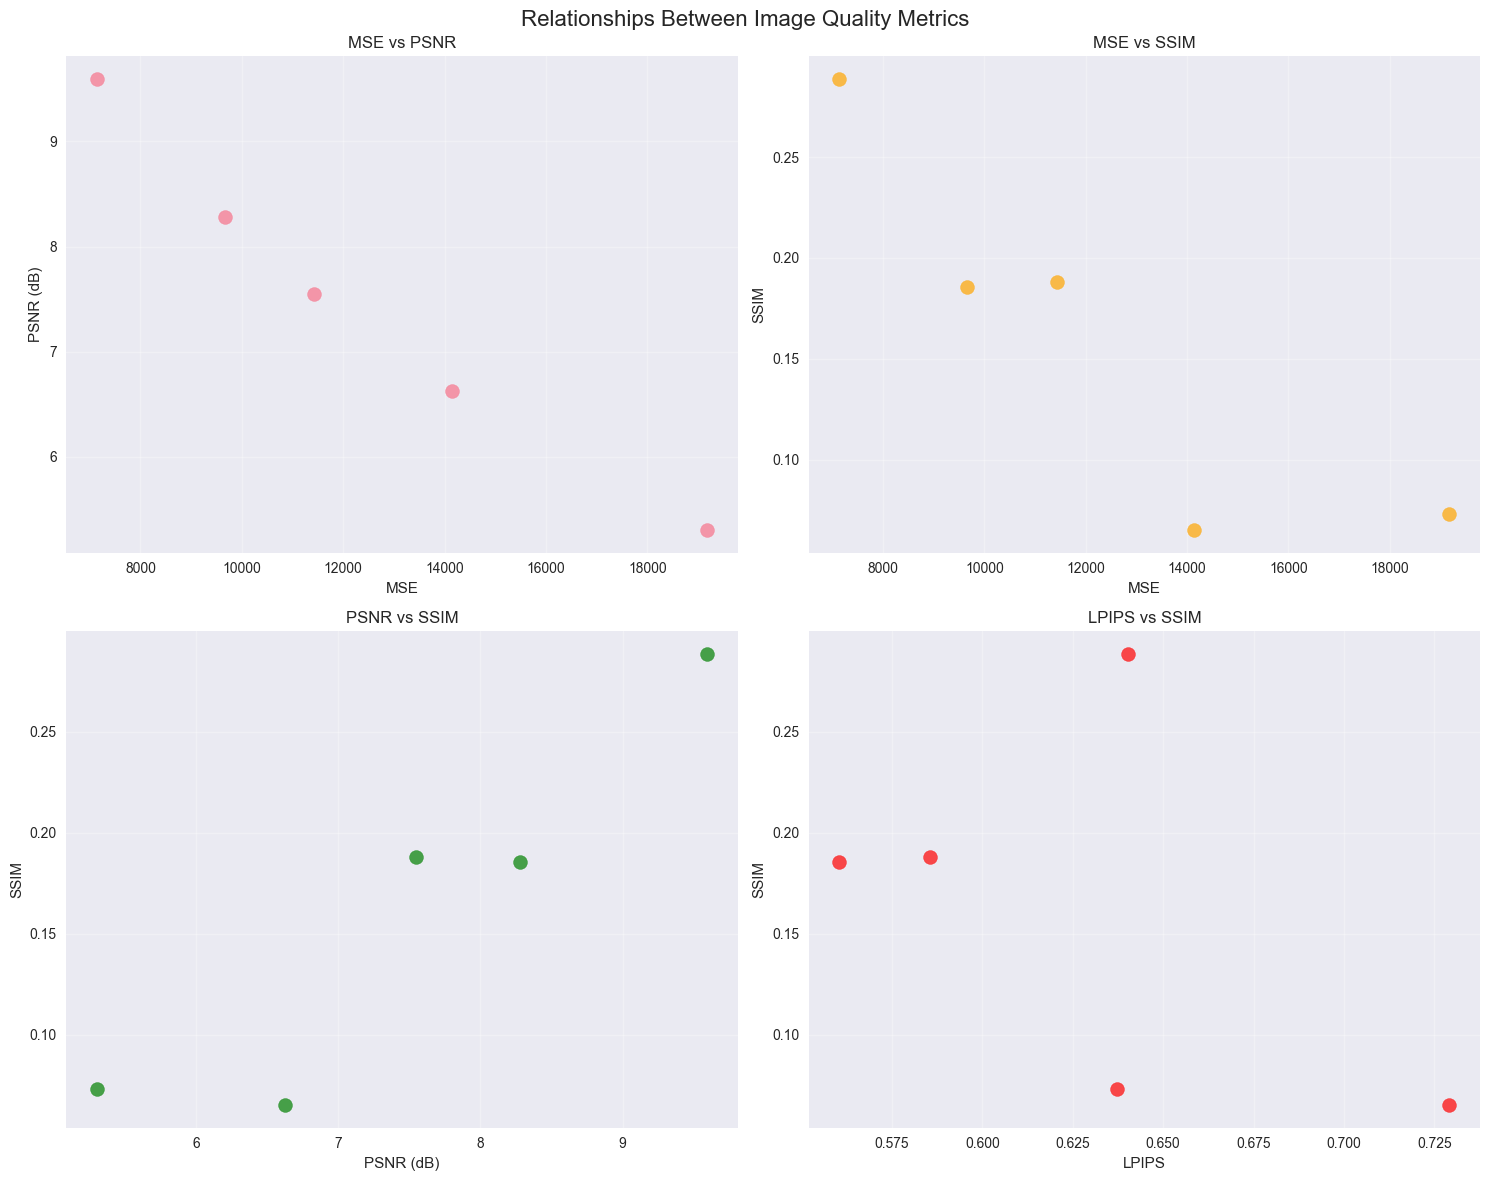

In [5]:
# Create scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationships Between Image Quality Metrics', fontsize=16)

# MSE vs PSNR
axes[0, 0].scatter(df['mse'], df['psnr'], alpha=0.7, s=100)
axes[0, 0].set_xlabel('MSE')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('MSE vs PSNR')
axes[0, 0].grid(True, alpha=0.3)

# MSE vs SSIM
axes[0, 1].scatter(df['mse'], df['ssim'], alpha=0.7, s=100, color='orange')
axes[0, 1].set_xlabel('MSE')
axes[0, 1].set_ylabel('SSIM')
axes[0, 1].set_title('MSE vs SSIM')
axes[0, 1].grid(True, alpha=0.3)

# PSNR vs SSIM
axes[1, 0].scatter(df['psnr'], df['ssim'], alpha=0.7, s=100, color='green')
axes[1, 0].set_xlabel('PSNR (dB)')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_title('PSNR vs SSIM')
axes[1, 0].grid(True, alpha=0.3)

# LPIPS vs SSIM
axes[1, 1].scatter(df['lpips'], df['ssim'], alpha=0.7, s=100, color='red')
axes[1, 1].set_xlabel('LPIPS')
axes[1, 1].set_ylabel('SSIM')
axes[1, 1].set_title('LPIPS vs SSIM')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
